In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform# , euclidean
import sklearn

from matplotlib.patches import Polygon

from sklearn.decomposition import PCA

In [2]:
# a function to flatten a list
def flatten(regular_list):
    flat_list = [item for sublist in regular_list for item in sublist]
    
    return flat_list

In [3]:
# https://github.com/DanChitwood/PassifloraLeaves/blob/master/Paper1/Figure2/0.procrustes_landmarks.txt
mdata = pd.read_csv('passiflora.csv')

# add a column for heteroblasty (positioning of leaf on stem)
mdata['heteroblasty'] = mdata['ontogeny'] / mdata['total']

In [4]:
# we do not use these columns
mdata = mdata.drop(columns=['plant','ontogeny','total'])

In [5]:
# rename index column
mdata.index.name='plant'

In [6]:
# divide species into seven classes based on the paper
# https://academic.oup.com/gigascience/article/6/1/giw008/2865207?login=true#supplementary-data
species_classes = {'miniata':6,
 'amethystina':3,
 'alata':5,
 'rubra':1,
 'misera':0,
 'setacea':2,
 'triloba':4,
 'nitida':5,
 'actinia':4,
 'villosa':5,
 'micropetala':1,
 'mucronata':6,
 'maliformis':6,
 'miersii':4,
 'malacophylla':6,
 'gibertii':2,
 'mollissima':2,
 'caerulea':2,
 'gracilis':3,
 'foetida':3,
 'racemosa':5,
 'tenuifila':2,
 'cristalina':6,
 'ligularis':5,
 'cincinnata':2,
 'coccinea':6,
 'hatschbachii':2,
 'morifolia':3,
 'organensis':1,
 'capsularis':1,
 'edmundoi':2,
 'galbana':6,
 'tricuspis':1,
 'pohlii':1,
 'biflora':1,
 'sidifolia':4,
 'suberosa':2,
 'edulis':5,
 'coriacea':0,
 'kermesina':2}

In [7]:
# replace species names with class in dataset
mdata = mdata.replace(species_classes)

In [8]:
# get array of leaf coordinates
xs = mdata.filter(regex="^x[0-9]+").to_numpy()
ys = mdata.filter(regex="^y[0-9]+").to_numpy()
lmks = np.stack((xs, ys), axis=2)

In [9]:
# get dataframe of coordinate values
procrustes_coords = pd.DataFrame([flatten(i) for i in lmks])

In [10]:
# get mean of each coordinate
lmk_mean = np.reshape(list(procrustes_coords.mean(axis=0)), (15, 2))

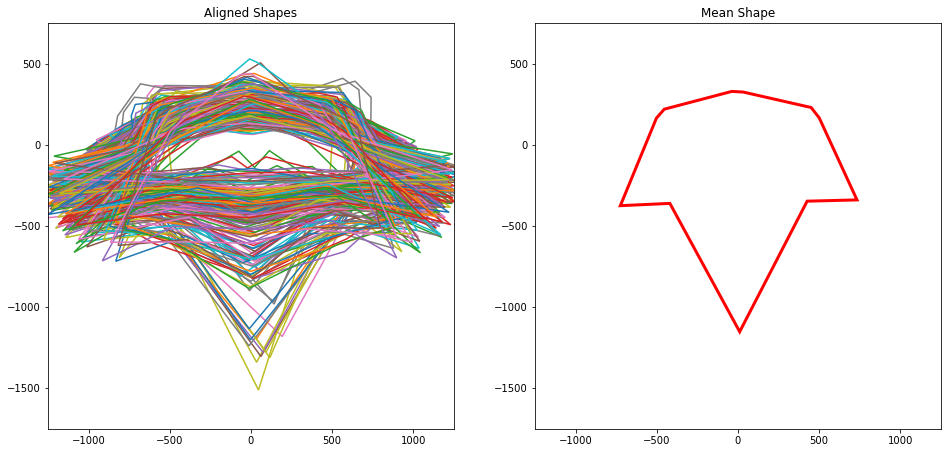

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 8)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for ax in axs:
    ax.set_xlim(left=-1250, right=1250)
    ax.set_ylim(bottom=-1750, top=750)
    ax.set(adjustable='box', aspect='equal')

# plot leaves from morphotype 0
for i in mdata[mdata['species']==0].index:
    col = colors[i % len(colors)]

    pa_xy = lmks[i][[5, 14, 13, 12, 11, 10, 9, 8, 7, 6, 0]]
    pa = Polygon(pa_xy, edgecolor=col, facecolor='none', linewidth=1.5)
    axs[0].add_patch(pa)
    axs[0].set_title('Aligned Shapes')
    
    
# plot the mean of all leaves from morphotype 0
pm = Polygon(lmk_mean[[5, 14, 13, 12, 11, 10, 9, 8, 7, 6, 0]], edgecolor='red', facecolor='none', linewidth=3)
axs[1].add_patch(pm)
axs[1].set_title('Mean Shape')

plt.show()

# Compute leaf distance

In [12]:
# get flattened coordinate matrix
landmark_matrix = np.array(procrustes_coords)

In [13]:
# compute correlation distance across all pairs of leaves
distance_correlation = squareform(pdist(landmark_matrix, 'correlation'))

# Lenses

## PCA lens

In [14]:
pca = PCA(n_components=6)

principalComponents = pca.fit_transform(landmark_matrix)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])

In [15]:
finalDf = pd.concat([principalDf, mdata[['species']]], axis = 1)

In [16]:
morphotypes = {0: 'A', 1: 'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G'}

In [17]:
finalDf['species'] = finalDf['species'].replace(morphotypes)

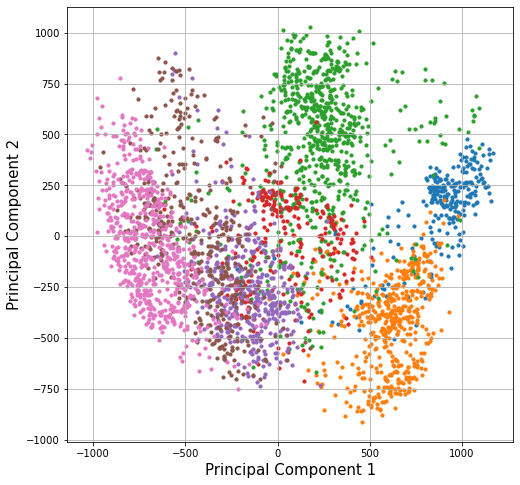

In [18]:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)

targets = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
#targets = range(1, 8)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['species'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 10)
# ax.legend(targets, title="Morphotype")
#ax.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c = mdata['heteroblasty'], s = 5, cmap='inferno')
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.grid()

fig.savefig('../papers/Passiflora/Figure_2/B/PCA_passiflora.svg')
# plt.savefig('../posters/ATMCS/PCA.svg', format='svg')

## Heteroblasty lens

In [19]:
heteroblasty_lens = np.array(mdata['heteroblasty'].tolist())

# Mapper algorithm

In [20]:
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

In [21]:
# takes as input the nth row of the landmark_matrix and returns the heteroblasty of the nth leaf
def heteroblasty_func(i):
    index = np.where(landmark_matrix == i)[0][0]
    heteroblasty_value = mdata.loc[index].heteroblasty
    
    return heteroblasty_value

In [22]:
# takes as input the nth row of the landmark_matrix and returns the PCA of the nth leaf
def PCA_func(i):
    index = np.where(landmark_matrix == i)[0][0]
    PCA_value = finalDf.loc[index]['principal component 1']
    
    return PCA_value

In [29]:
cover = CubicalCover(n_intervals=39, overlap_frac=0.65)

pipe = make_mapper_pipeline(
    filter_func=heteroblasty_func,
    cover=cover,
    clusterer=sklearn.cluster.DBSCAN(eps = 0.021, min_samples = 2, metric = 'correlation'),
    verbose=True,
    store_edge_elements=True
)

In [30]:
fig = plot_static_mapper_graph(pipe, landmark_matrix, layout = 'fruchterman_reingold', layout_dim = 3)
fig.show(config={'scrollZoom': True})
# fig.write_html("3d_mapper.html")

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   1.5s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   1.5s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


In [31]:
graph2 = pipe.fit_transform(landmark_matrix)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   1.5s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   1.5s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


In [32]:
node_elements = graph2.vs["node_elements"]

In [40]:
len(set(flatten(node_elements)))

3319

In [27]:
mdata.loc[node_elements[36]]

,species,heteroblasty,x1,y1,x2,y2,x3,y3,x4,y4,...,x11,y11,x12,y12,x13,y13,x14,y14,x15,y15
plant,,,,,,,,,,,,,,,,,,,,,
47,4,0.739130,-28.257505,419.661020,-39.105545,399.334094,-29.494819,353.720109,15.744699,358.958566,...,43.800906,-1416.427054,563.231693,-461.476824,575.460625,-350.468084,530.052085,151.741359,505.056932,200.341246
65,4,0.750000,-50.564792,341.818294,-54.620457,323.488893,-46.950030,288.971456,-11.971330,274.373915,...,110.806049,-1204.924457,729.701233,-482.987215,734.493816,-428.858094,542.242032,229.101057,488.617257,267.908357
99,5,0.733333,-10.852147,466.879797,-9.209887,449.017122,5.032151,285.004434,29.372164,305.059269,...,-74.675366,-1444.129251,554.401813,-417.911176,567.291306,-317.208046,495.310294,195.912579,466.021404,251.099776
144,5,0.727273,-29.220273,396.156770,-29.522570,379.750048,-22.836625,314.318521,12.055876,315.563296,...,7.920623,-1384.448468,628.064605,-418.819018,636.816485,-336.551766,536.693378,175.830653,509.986445,224.694424
156,5,0.750000,-29.410760,474.046785,-23.813659,439.707133,-19.778597,121.450411,21.986467,220.052644,...,-6.437352,-1609.275998,530.443027,-256.981207,510.100331,-145.402685,461.558445,19.156958,426.259085,89.254658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,1,0.727273,-24.832502,239.880685,-38.035368,230.208793,-25.336295,200.977839,7.094949,189.605930,...,-17.899316,-580.725446,661.638783,-562.076347,980.584861,-426.465690,425.005925,338.075449,328.577736,331.976702
3213,1,0.727273,-11.630533,295.384594,-19.035005,279.891169,-6.380112,263.309907,18.843172,259.944922,...,5.829988,-587.037763,590.410022,-616.284618,961.613443,-573.948554,463.970739,301.349515,326.383747,321.579347
3256,1,0.750000,-170.989325,201.223849,-192.884121,188.888009,-54.656294,253.323769,-20.429087,251.978960,...,-29.417109,-640.632018,717.946833,-455.314763,935.566878,-373.027998,590.158759,246.909756,512.102436,279.714251


In [28]:
giotto_edges = []

for e in graph2.es:
    giotto_edges.append(list(e.tuple))